# Idea

We assume that when an asset is trading above its moving average, it is overvalued and will revert to its moving average in price, acting as a signal to sell or short the asset. Conversely, when an asset is trading below its moving average, we assume that it is undervalued and will also revert to its moving average in price, acting as a signal to buy the asset.

We consider the following dimensions of variation:
  - time horizons for measuring price: 4h, 8h, 12h, 1d, 2d
  - signal calculation of price relative to average: raw difference, percent change
  - type of moving average: simple moving average vs. exponentially weighted moving average
      - window size for simple moving average
      - alpha decay for exponentially weighted-moving average

# Summary

Historical data is from the period 2020-12-20 to 2025-08-31. We use the period from 2020-12-20 to 2023-12-31 as training data for the different parameter variations and the period from 2024-01-01 to 2025-08-31 as testing data.

# Imports

In [139]:
import pandas as pd

from binance.client import Client as bnb_client
from datetime import datetime, timedelta

from ipynb.fs.full.utility_functions import (
    get_train_test_data,
    get_rank_demeaned_normalized_signal,
    get_gross_returns_and_net_returns,
    get_strategy_stats,
    get_winsorized_signal,
    get_truncated_signal,
    get_rank_thresholded_signal,
)

# Get Historical Data For Cryptocurrencies

In [2]:
# The universe is based on this snapshot from December 20, 2020: https://coinmarketcap.com/historical/20201220/

univ = [
    "BTCUSDT", "ETHUSDT", "ADAUSDT", "BNBUSDT", "XRPUSDT", "DOTUSDT", "MATICUSDT", "LTCUSDT", "BCHUSDT",
    "LINKUSDT", "XLMUSDT", "USDCUSDT", "EOSUSDT", "TRXUSDT", "XTZUSDT", "FILUSDT", "NEOUSDT", "DAIUSDT",
    "DASHUSDT", "VETUSDT", "ATOMUSDT", "AAVEUSDT", "UNIUSDT", "GRTUSDT", "THETAUSDT", "IOTAUSDT", "BUSDUSDT",
    "ZECUSDT", "YFIUSDT", "ETCUSDT", "WAVESUSDT", "COMPUSDT", "SNXUSDT", "DOGEUSDT", "MKRUSDT", "ZILUSDT",
    "SUSHIUSDT", "KSMUSDT", "OMGUSDT", "ONTUSDT", "ALGOUSDT", "EGLDUSDT", "BATUSDT", "DGBUSDT", "ZRXUSDT",
    "TUSDUSDT", "QTUMUSDT", "ICXUSDT", "AVAXUSDT", "RENUSDT", "HBARUSDT", "NEARUSDT", "LRCUSDT", "CELOUSDT",
    "KNCUSDT", "LSKUSDT", "OCEANUSDT", "QNTUSDT", "USTUSDT", "BANDUSDT", "MANAUSDT", "ENJUSDT", "ANTUSDT",
    "BNTUSDT", "ZENUSDT", "NMRUSDT", "RVNUSDT", "IOSTUSDT", "OXTUSDT", "CRVUSDT", "MATICUSDT", "HNTUSDT",
    "BALUSDT", "CHZUSDT"
]

should_download_stock_data = False

In [3]:
client = bnb_client(tld='US')

def get_binance_px(symbol, freq, start_ts = '2020-12-20'):
    data = client.get_historical_klines(symbol, freq, start_ts)
    columns = ['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_volume',
               'num_trades', 'taker_base_volume', 'taker_quote_volume', 'ignore']
    data = pd.DataFrame(data, columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 


if should_download_stock_data:
    freq = '4h'
    px = {}
    for x in univ:
        print(f"Downloading data for symbol {x}")
        data = get_binance_px(x, freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px.to_csv('./class_project_input_prices.csv')
else:
    px = pd.read_csv('./class_project_input_prices.csv')
    date_format = "%Y-%m-%d %H:%M:%S"
    px['open_time'] = px['open_time'].apply(lambda t:  datetime.strptime(t, date_format))
    px.set_index('open_time', inplace=True)

# Data up to 2025-08-31 08:00:00
px

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT,LTCUSDT,BCHUSDT,LINKUSDT,...,BNTUSDT,ZENUSDT,NMRUSDT,RVNUSDT,IOSTUSDT,OXTUSDT,CRVUSDT,HNTUSDT,BALUSDT,CHZUSDT
open_time,,,,,,,,,,,,,,,,,,,,,
2020-12-20 00:00:00,23353.97,646.62,0.16284,32.9681,0.56944,NaN,NaN,117.34,313.46,NaN,...,NaN,12.056,NaN,NaN,NaN,0.2492,NaN,1.41095,NaN,NaN
2020-12-20 04:00:00,23604.24,655.23,0.16638,33.6559,0.57916,NaN,NaN,121.30,340.00,NaN,...,NaN,12.107,NaN,NaN,NaN,0.2477,NaN,1.43156,NaN,NaN
2020-12-20 08:00:00,23549.50,652.88,0.16463,34.8228,0.57948,NaN,NaN,118.09,349.70,NaN,...,NaN,12.237,NaN,NaN,NaN,0.2477,NaN,1.44273,NaN,NaN
2020-12-20 12:00:00,23880.85,653.24,0.16542,35.0120,0.57798,NaN,NaN,119.10,361.21,NaN,...,NaN,12.074,NaN,NaN,NaN,0.2533,NaN,1.47130,NaN,NaN
2020-12-20 16:00:00,23932.71,649.82,0.16502,34.7042,0.57306,NaN,NaN,116.60,357.09,NaN,...,NaN,12.008,NaN,NaN,NaN,0.2503,NaN,1.43083,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-08-30 16:00:00,108921.64,4352.10,0.81950,856.7600,2.80720,3.816,NaN,110.23,542.00,23.36,...,0.725,7.240,16.62,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-30 20:00:00,108569.75,4374.56,0.82170,862.6200,2.81940,3.773,NaN,110.77,552.90,23.47,...,0.725,7.240,15.16,0.01323,0.00342,0.0535,0.7646,NaN,NaN,0.03830
2025-08-31 00:00:00,109155.73,4486.79,0.83590,863.4900,2.85180,3.867,NaN,111.67,551.30,23.90,...,0.764,7.240,15.21,0.01353,0.00342,0.0535,0.7936,NaN,NaN,0.04045


In [4]:
test_start_time_point = datetime(2024, 1, 1, 0, 0)

train_px, test_px = get_train_test_data(px, test_start_time_point)

In [133]:
from enum import Enum

class RollingMean(Enum):
    SIMPLE_ROLLING_MEAN = 1
    EXPONENTIAL_ROLLING_MEAN = 2


class SignalCalculation(Enum):
    RAW_DIFFERENCE = 1
    PERCENT = 2

    
def get_transformed_signal(train_px_df, rolling_mean_type, signal_type, num_periods, alpha):
    if rolling_mean_type == RollingMean.SIMPLE_ROLLING_MEAN:
        rolling_avg = train_px_df.rolling(num_periods).mean()
    elif rolling_mean_type == RollingMean.EXPONENTIAL_ROLLING_MEAN:
        rolling_avg = train_px_df.ewm(alpha = alpha, min_periods=12).mean()
    
    if signal_type == SignalCalculation.RAW_DIFFERENCE:
        raw_signal = rolling_avg - train_px_df
    elif signal_type == SignalCalculation.PERCENT:
        raw_signal = -1 * (train_px_df - rolling_avg) / rolling_avg
        
    return get_rank_demeaned_normalized_signal(raw_signal)


def get_training_period_strategy_stats(
    train_px_df,
    trade_hours_freq,
    rolling_mean_type,
    signal_type,
    num_periods = None,
    alpha = 1.0,
):
    transformed_signal = get_transformed_signal(
        train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
    gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)
    
    return pd.Series(get_strategy_stats(net_returns, trade_hours_freq, train_px_df), name = "Stats")


horizon_to_training_px = {
    4: train_px,
    8: train_px[train_px.index.hour % 8 == 0],
    12: train_px[train_px.index.hour % 12 == 0],
    24: train_px[train_px.index.hour == 0],
    48: train_px[train_px.index.hour == 0].loc[
        pd.date_range(start=datetime(2020, 12, 20), end=datetime(2023, 12, 31), freq='2D')
    ],
}


def get_strategy_stats_for_parameter_set(stat_func):
    stats_map = dict()

    for time_horizon_hours in (4, 8, 12, 24, 48):
        for signal_type in (SignalCalculation.RAW_DIFFERENCE, SignalCalculation.PERCENT):

            # simple rolling mean
            for num_periods in (6, 12, 18, 24, 6 * 7, 6 * 7 * 2, 6 * 7 * 4):
                key = (time_horizon_hours, signal_type, "simple rolling", num_periods)
                stats_map[key] = stat_func(
                    horizon_to_training_px[time_horizon_hours],
                    time_horizon_hours,
                    RollingMean.SIMPLE_ROLLING_MEAN,
                    signal_type,
                    num_periods = num_periods)

            # exponentially weighted moving average
            for alpha in (0.1, 0.2, 0.25, 0.5, 0.75, 0.8, 0.9):
                key = (time_horizon_hours, signal_type, "exponential weighted", alpha)
                stats_map[key] = stat_func(
                    horizon_to_training_px[time_horizon_hours],
                    time_horizon_hours,
                    RollingMean.EXPONENTIAL_ROLLING_MEAN,
                    signal_type,
                    alpha=alpha)
    
    return pd.DataFrame(stats_map).T

In [134]:
stats_df = get_strategy_stats_for_parameter_set(get_training_period_strategy_stats)
stats_df.sort_values(by='sharpe ratio', ascending=False).iloc[:20]

avg returns  \
4  SignalCalculation.PERCENT exponential weighted 0.10       1.212564   
                             simple rolling       18.00      1.168977   
                                                  24.00      1.160458   
                                                  42.00      1.145518   
                                                  12.00      1.106270   
                                                  84.00      1.059602   
                                                  168.00     0.973805   
                             exponential weighted 0.20       1.029594   
                                                  0.25       0.823131   
8  SignalCalculation.PERCENT simple rolling       168.00     0.636698   
                             exponential weighted 0.10       0.739757   
                             simple rolling       42.00      0.691089   
                                                  84.00      0.652710   
                                                  18.00      0.676575   
                                                  24.00      0.655616   
                             exponential weighted 0.20       0.640796   
                             simple rolling       12.00      0.629496   
12 SignalCalculation.PERCENT simple rolling       168.00     0.428127   
                                                  84.00      0.467017   
8  SignalCalculation.PERCENT exponential weighted 0.25       0.566146   

                                                          decorrelated avg returns  \
4  SignalCalculation.PERCENT exponential weighted 0.10                    1.198052   
                             simple rolling       18.00                   1.155293   
                                                  24.00                   1.146951   
                                                  42.00                   1.130881   
                                                  12.00                   1.094415   
                                                  84.00                   1.048450   
                                                  168.00                  0.964534   
                             exponential weighted 0.20                    1.016140   
                                                  0.25                    0.810476   
8  SignalCalculation.PERCENT simple rolling       168.00                  0.626716   
                             exponential weighted 0.10                    0.727623   
                             simple rolling       42.00                   0.679382   
                                                  84.00                   0.639059   
                                                  18.00                   0.664472   
                                                  24.00                   0.644421   
                             exponential weighted 0.20                    0.630293   
                             simple rolling       12.00                   0.617575   
12 SignalCalculation.PERCENT simple rolling       168.00                  0.416055   
                                                  84.00                   0.453520   
8  SignalCalculation.PERCENT exponential weighted 0.25                    0.556194   

                                                          volatility  \
4  SignalCalculation.PERCENT exponential weighted 0.10      0.356716   
                             simple rolling       18.00     0.356527   
                                                  24.00     0.354656   
                                                  42.00     0.351669   
                                                  12.00     0.356306   
                                                  84.00     0.342709   
                                                  168.00    0.329427   
                             exponential weighted 0.20      0.354884   
                                                  0.25      0.351853 

In [39]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.EXPONENTIAL_ROLLING_MEAN
num_periods = None
alpha = 0.10

transformed_signal = get_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

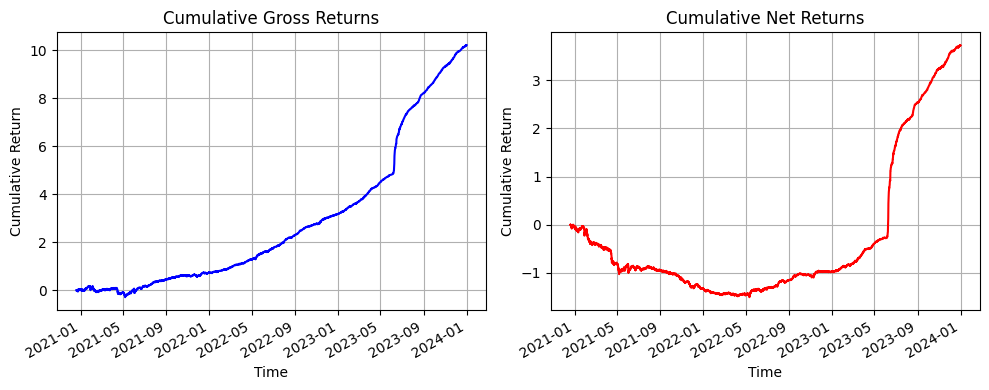

In [46]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [47]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 18
alpha = 0.10

transformed_signal = get_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

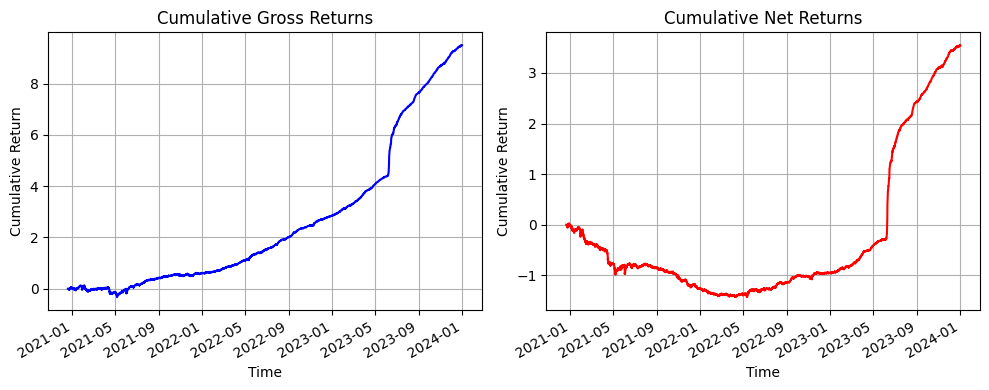

In [48]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [49]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 24
alpha = 0.10

transformed_signal = get_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

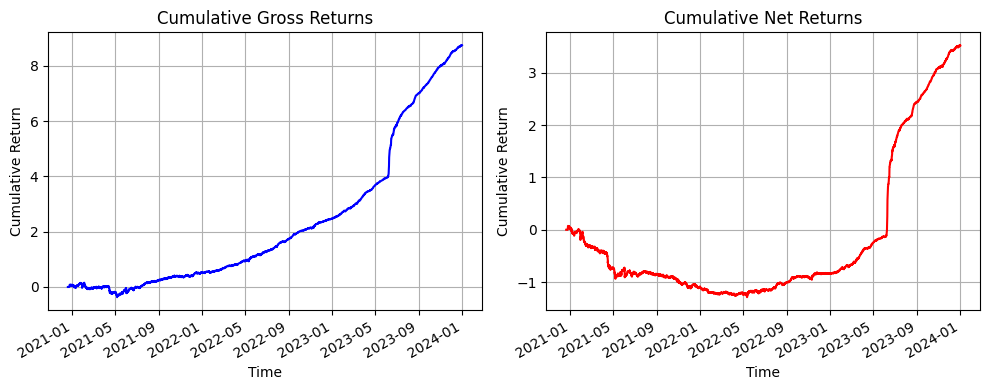

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [ ]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 84
alpha = 0.10

transformed_signal = get_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

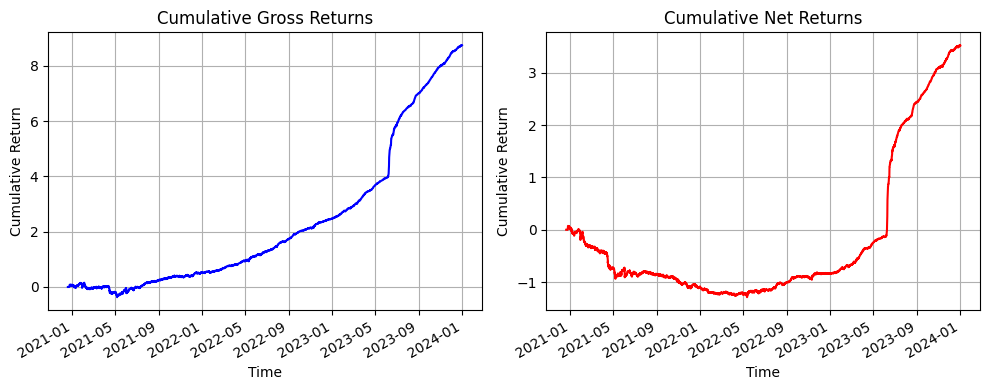

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [93]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.RAW_DIFFERENCE
rolling_mean_type = RollingMean.EXPONENTIAL_ROLLING_MEAN
num_periods = 84
alpha = 0.90

transformed_signal = get_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

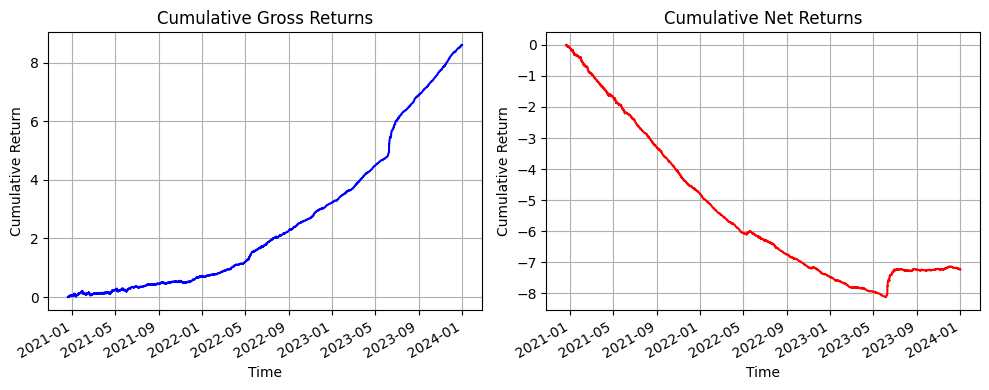

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [98]:
train_px_df = horizon_to_training_px[8]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.EXPONENTIAL_ROLLING_MEAN
num_periods = None
alpha = 0.10

transformed_signal = get_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

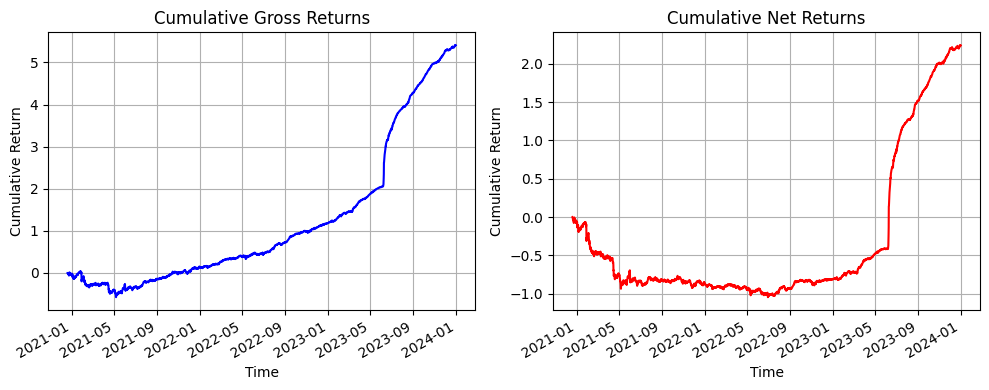

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

In [111]:
train_px_df = horizon_to_training_px[8]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 168
alpha = 0.10

transformed_signal = get_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

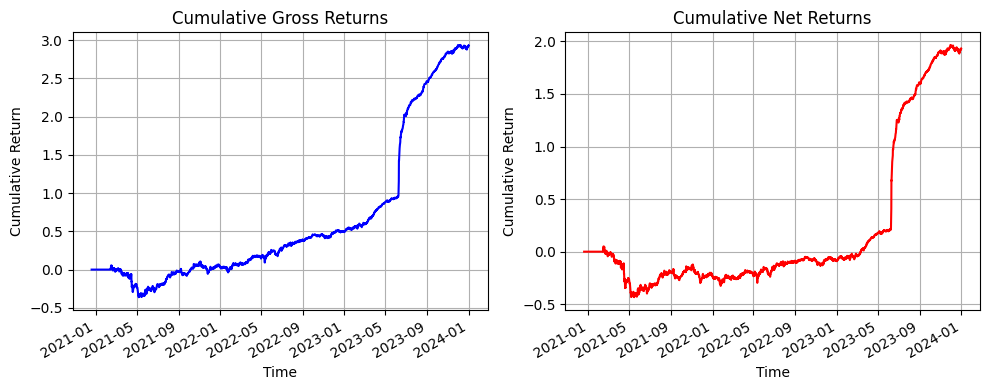

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

# Winsorized Signal

In [123]:
def get_winsorized_transformed_signal(train_px_df, rolling_mean_type, signal_type, num_periods, alpha):
    if rolling_mean_type == RollingMean.SIMPLE_ROLLING_MEAN:
        rolling_avg = train_px_df.rolling(num_periods).mean()
    elif rolling_mean_type == RollingMean.EXPONENTIAL_ROLLING_MEAN:
        rolling_avg = train_px_df.ewm(alpha = alpha, min_periods=12).mean()
    
    if signal_type == SignalCalculation.RAW_DIFFERENCE:
        raw_signal = rolling_avg - train_px_df
    elif signal_type == SignalCalculation.PERCENT:
        raw_signal = -1 * (train_px_df - rolling_avg) / rolling_avg
        
    return get_rank_demeaned_normalized_signal(get_winsorized_signal(raw_signal, 0.1, 0.1))


def get_winsorized_training_period_strategy_stats(
    train_px_df,
    trade_hours_freq,
    rolling_mean_type,
    signal_type,
    num_periods = None,
    alpha = 1.0,
):
    transformed_signal = get_winsorized_transformed_signal(
        train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
    gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)
    
    return pd.Series(get_strategy_stats(net_returns, trade_hours_freq, train_px_df), name = "Stats")

In [135]:
stats_df = get_strategy_stats_for_parameter_set(get_winsorized_training_period_strategy_stats)
stats_df.sort_values(by='sharpe ratio', ascending=False).iloc[:20]

avg returns  \
4  SignalCalculation.PERCENT exponential weighted 0.10       1.185569   
                             simple rolling       24.00      1.120310   
                                                  42.00      1.110334   
                                                  18.00      1.120527   
                                                  12.00      1.074980   
                                                  84.00      1.033532   
                                                  168.00     0.950338   
                             exponential weighted 0.20       1.011917   
                                                  0.25       0.802210   
8  SignalCalculation.PERCENT exponential weighted 0.10       0.708361   
                             simple rolling       42.00      0.673950   
                                                  168.00     0.602100   
                                                  84.00      0.642964   
                                                  18.00      0.657705   
                                                  24.00      0.627166   
                             exponential weighted 0.20       0.621425   
                             simple rolling       12.00      0.605263   
12 SignalCalculation.PERCENT simple rolling       168.00     0.401634   
8  SignalCalculation.PERCENT exponential weighted 0.25       0.538289   
12 SignalCalculation.PERCENT simple rolling       42.00      0.491122   

                                                          decorrelated avg returns  \
4  SignalCalculation.PERCENT exponential weighted 0.10                    1.173443   
                             simple rolling       24.00                   1.109021   
                                                  42.00                   1.097611   
                                                  18.00                   1.109012   
                                                  12.00                   1.065383   
                                                  84.00                   1.025078   
                                                  168.00                  0.943650   
                             exponential weighted 0.20                    1.000852   
                                                  0.25                    0.792118   
8  SignalCalculation.PERCENT exponential weighted 0.10                    0.698502   
                             simple rolling       42.00                   0.665216   
                                                  168.00                  0.594784   
                                                  84.00                   0.632533   
                                                  18.00                   0.647927   
                                                  24.00                   0.618199   
                             exponential weighted 0.20                    0.613514   
                             simple rolling       12.00                   0.595764   
12 SignalCalculation.PERCENT simple rolling       168.00                  0.392080   
8  SignalCalculation.PERCENT exponential weighted 0.25                    0.531101   
12 SignalCalculation.PERCENT simple rolling       42.00                   0.482094   

                                                          volatility  \
4  SignalCalculation.PERCENT exponential weighted 0.10      0.337448   
                             simple rolling       24.00     0.335378   
                                                  42.00     0.332746   
                                                  18.00     0.337690   
                                                  12.00     0.337712   
                                                  84.00     0.324944   
                                                  168.00    0.316686   
                             exponential weighted 0.20      0.337744   
                                                  0.25      0.335137 

In [125]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.EXPONENTIAL_ROLLING_MEAN
num_periods = None
alpha = 0.10

transformed_signal = get_winsorized_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

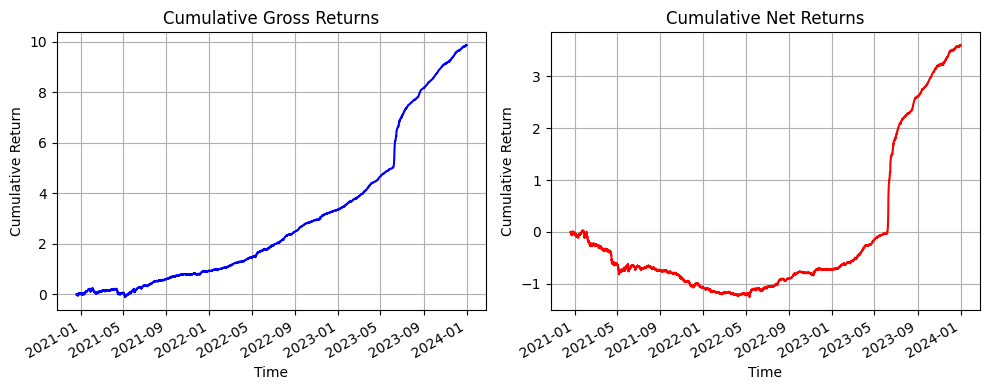

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

# Truncated Signal

In [130]:
def get_truncated_transformed_signal(train_px_df, rolling_mean_type, signal_type, num_periods, alpha):
    if rolling_mean_type == RollingMean.SIMPLE_ROLLING_MEAN:
        rolling_avg = train_px_df.rolling(num_periods).mean()
    elif rolling_mean_type == RollingMean.EXPONENTIAL_ROLLING_MEAN:
        rolling_avg = train_px_df.ewm(alpha = alpha, min_periods=12).mean()
    
    if signal_type == SignalCalculation.RAW_DIFFERENCE:
        raw_signal = rolling_avg - train_px_df
    elif signal_type == SignalCalculation.PERCENT:
        raw_signal = -1 * (train_px_df - rolling_avg) / rolling_avg
        
    return get_rank_demeaned_normalized_signal(get_truncated_signal(raw_signal, 0.1, 0.1))


def get_truncated_training_period_strategy_stats(
    train_px_df,
    trade_hours_freq,
    rolling_mean_type,
    signal_type,
    num_periods = None,
    alpha = 1.0,
):
    transformed_signal = get_truncated_transformed_signal(
        train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
    gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)
    
    return pd.Series(get_strategy_stats(net_returns, trade_hours_freq, train_px_df), name = "Stats")

In [136]:
stats_df = get_strategy_stats_for_parameter_set(get_truncated_training_period_strategy_stats)
stats_df.sort_values(by='sharpe ratio', ascending=False).iloc[:20]

avg returns  \
48 SignalCalculation.PERCENT        simple rolling       84.00      0.105163   
24 SignalCalculation.PERCENT        simple rolling       168.00     0.075351   
48 SignalCalculation.RAW_DIFFERENCE simple rolling       42.00      0.074977   
                                                         18.00      0.188508   
                                    exponential weighted 0.10       0.139242   
   SignalCalculation.PERCENT        simple rolling       18.00      0.149775   
12 SignalCalculation.RAW_DIFFERENCE simple rolling       168.00     0.061241   
48 SignalCalculation.PERCENT        simple rolling       168.00     0.034168   
                                    exponential weighted 0.10       0.096627   
24 SignalCalculation.RAW_DIFFERENCE simple rolling       84.00      0.025586   
48 SignalCalculation.PERCENT        exponential weighted 0.25       0.034288   
                                                         0.20      -0.004400   
   SignalCalculation.RAW_DIFFERENCE simple rolling       84.00     -0.002984   
24 SignalCalculation.PERCENT        simple rolling       18.00     -0.026262   
48 SignalCalculation.PERCENT        simple rolling       6.00      -0.026129   
   SignalCalculation.RAW_DIFFERENCE simple rolling       12.00     -0.019507   
24 SignalCalculation.PERCENT        simple rolling       84.00     -0.022468   
48 SignalCalculation.PERCENT        simple rolling       42.00     -0.023364   
12 SignalCalculation.PERCENT        simple rolling       168.00    -0.035010   
24 SignalCalculation.RAW_DIFFERENCE simple rolling       168.00    -0.031011   

                                                                 decorrelated avg returns  \
48 SignalCalculation.PERCENT        simple rolling       84.00                   0.092093   
24 SignalCalculation.PERCENT        simple rolling       168.00                  0.064234   
48 SignalCalculation.RAW_DIFFERENCE simple rolling       42.00                   0.061379   
                                                         18.00                   0.175961   
                                    exponential weighted 0.10                    0.126121   
   SignalCalculation.PERCENT        simple rolling       18.00                   0.122132   
12 SignalCalculation.RAW_DIFFERENCE simple rolling       168.00                  0.052075   
48 SignalCalculation.PERCENT        simple rolling       168.00                  0.026871   
                                    exponential weighted 0.10                    0.064275   
24 SignalCalculation.RAW_DIFFERENCE simple rolling       84.00                   0.014692   
48 SignalCalculation.PERCENT        exponential weighted 0.25                    0.002833   
                                                         0.20                   -0.035965   
   SignalCalculation.RAW_DIFFERENCE simple rolling       84.00                  -0.018370   
24 SignalCalculation.PERCENT        simple rolling       18.00                  -0.060844   
48 SignalCalculation.PERCENT        simple rolling       6.00                   -0.051145   
   SignalCalculation.RAW_DIFFERENCE simple rolling       12.00                  -0.024145   
24 SignalCalculation.PERCENT        simple rolling       84.00                  -0.029194   
48 SignalCalculation.PERCENT        simple rolling       42.00                  -0.032554   
12 SignalCalculation.PERCENT        simple rolling       168.00                 -0.041153   
24 SignalCalculation.RAW_DIFFERENCE simple rolling       168.00                 -0.041181   

                                                                 volatility  \
48 SignalCalculation.PERCENT        simple rolling       84.00     0.146939   
24 SignalCalculation.PERCENT        simple rolling       168.00    0.150005   
48 SignalCalculation.RAW_DIFFERENCE simple rolling       42.00     0.170062   
                                                         18.00     0.457349   
                                   

In [137]:
train_px_df = horizon_to_training_px[48]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 84
alpha = 0.0

transformed_signal = get_truncated_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

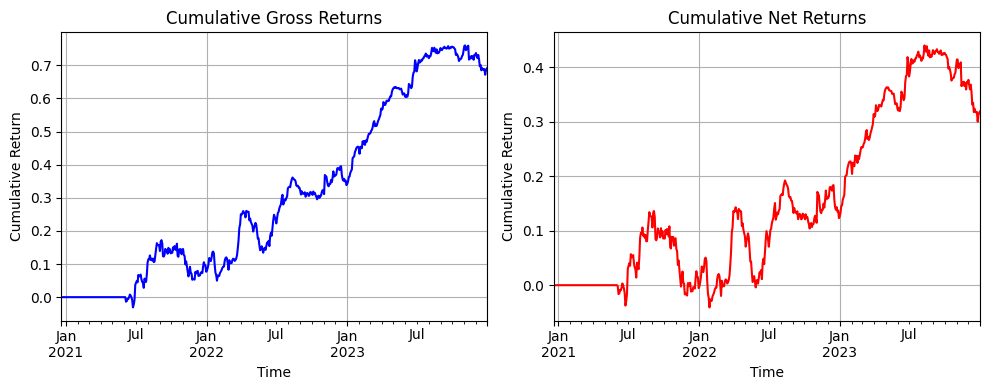

In [138]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()

# Rank-Thresholded Signal

In [146]:
def get_rank_thresholded_transformed_signal(train_px_df, rolling_mean_type, signal_type, num_periods, alpha):
    if rolling_mean_type == RollingMean.SIMPLE_ROLLING_MEAN:
        rolling_avg = train_px_df.rolling(num_periods).mean()
    elif rolling_mean_type == RollingMean.EXPONENTIAL_ROLLING_MEAN:
        rolling_avg = train_px_df.ewm(alpha = alpha, min_periods=12).mean()
    
    if signal_type == SignalCalculation.RAW_DIFFERENCE:
        raw_signal = rolling_avg - train_px_df
    elif signal_type == SignalCalculation.PERCENT:
        raw_signal = -1 * (train_px_df - rolling_avg) / rolling_avg
        
    return get_rank_demeaned_normalized_signal(get_rank_thresholded_signal(raw_signal, 0.2, 0.2))
    #return get_rank_thresholded_signal(get_rank_demeaned_normalized_signal(raw_signal), 0.2, 0.2)


def get_rank_thresholded_training_period_strategy_stats(
    train_px_df,
    trade_hours_freq,
    rolling_mean_type,
    signal_type,
    num_periods = None,
    alpha = 1.0,
):
    transformed_signal = get_rank_thresholded_transformed_signal(
        train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
    gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)
    
    return pd.Series(get_strategy_stats(net_returns, trade_hours_freq, train_px_df), name = "Stats")

In [147]:
stats_df = get_strategy_stats_for_parameter_set(get_rank_thresholded_training_period_strategy_stats)
stats_df.sort_values(by='sharpe ratio', ascending=False).iloc[:20]

avg returns  \
4 SignalCalculation.PERCENT exponential weighted 0.10       2.138398   
                                                 0.20       2.096105   
                            simple rolling       12.00      2.117093   
                                                 18.00      2.090143   
                                                 24.00      2.012574   
                                                 42.00      1.916855   
                                                 84.00      1.824662   
                            exponential weighted 0.25       1.833393   
                            simple rolling       168.00     1.624483   
8 SignalCalculation.PERCENT exponential weighted 0.20       1.310891   
                                                 0.10       1.308770   
4 SignalCalculation.PERCENT simple rolling       6.00       1.284577   
8 SignalCalculation.PERCENT exponential weighted 0.25       1.292275   
                            simple rolling       168.00     1.044233   
                                                 42.00      1.200618   
                                                 18.00      1.226310   
                                                 12.00      1.192309   
                                                 6.00       1.168670   
                                                 24.00      1.161754   
                                                 84.00      1.051434   

                                                         decorrelated avg returns  \
4 SignalCalculation.PERCENT exponential weighted 0.10                    2.120475   
                                                 0.20                    2.081445   
                            simple rolling       12.00                   2.103809   
                                                 18.00                   2.072750   
                                                 24.00                   1.994644   
                                                 42.00                   1.897093   
                                                 84.00                   1.808062   
                            exponential weighted 0.25                    1.819470   
                            simple rolling       168.00                  1.610299   
8 SignalCalculation.PERCENT exponential weighted 0.20                    1.298217   
                                                 0.10                    1.293329   
4 SignalCalculation.PERCENT simple rolling       6.00                    1.271266   
8 SignalCalculation.PERCENT exponential weighted 0.25                    1.279210   
                            simple rolling       168.00                  1.030663   
                                                 42.00                   1.183744   
                                                 18.00                   1.212087   
                                                 12.00                   1.178080   
                                                 6.00                    1.161482   
                                                 24.00                   1.146362   
                                                 84.00                   1.032135   

                                                         volatility  \
4 SignalCalculation.PERCENT exponential weighted 0.10      0.705469   
                                                 0.20      0.696086   
                            simple rolling       12.00     0.705563   
                                                 18.00     0.705973   
                                                 24.00     0.703205   
                                                 42.00     0.699956   
                                                 84.00     0.679757   
                            exponential weighted 0.25      0.687852   
                            simple rolling       168.00    0.649842   
8 SignalCalculation.PERCENT exponential weighted

In [148]:
train_px_df = horizon_to_training_px[4]
signal_type = SignalCalculation.PERCENT
rolling_mean_type = RollingMean.SIMPLE_ROLLING_MEAN
num_periods = 24
alpha = 0.0

transformed_signal = get_rank_thresholded_transformed_signal(
    train_px_df, rolling_mean_type, signal_type, num_periods, alpha)
gross_returns, net_returns = get_gross_returns_and_net_returns(transformed_signal, train_px_df)

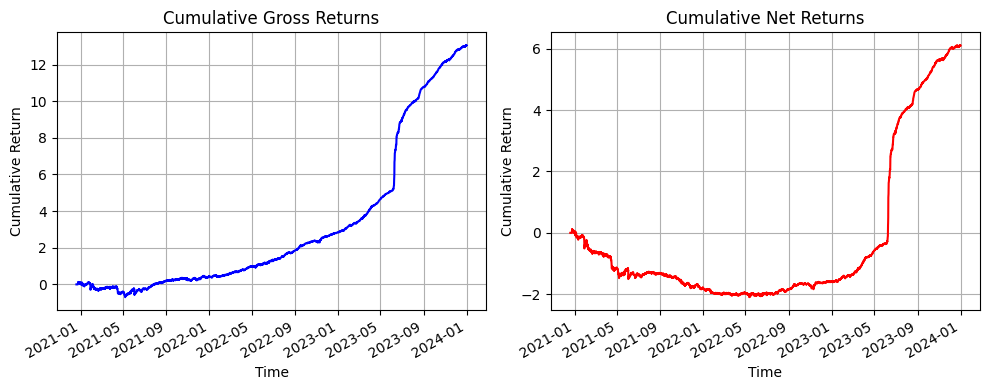

In [149]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

gross_returns.cumsum().plot(ax=axes[0], title='Cumulative Gross Returns', color='blue')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Cumulative Return')
axes[0].grid(True)

# Plot the second Series on the second subplot (axes[1])
net_returns.cumsum().plot(ax=axes[1], title='Cumulative Net Returns', color='red')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Cumulative Return')
axes[1].grid(True)

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()

# Display the plots
plt.show()